### Required imports

In [437]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd 
from sklearn.decomposition import TruncatedSVD
from sklearn.grid_search import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, scale
from sklearn.svm import LinearSVC
from sklearn.utils.extmath import randomized_svd
from xgboost import XGBClassifier

%matplotlib inline

### Data load

In [106]:
data_mat = pd.read_csv("./data/student/student-mat.csv", sep=";")
data_por = pd.read_csv("./data/student/student-por.csv", sep=";")

In [41]:
data_mat.shape

(395, 33)

In [107]:
data_por.shape

(649, 33)

Probably, we'd better to concatenate data keeping the course taken as a feature.

In [117]:
# zeros and ones are chosen so as to more abundant class to be represented as ones.
data = pd.concat([
        pd.concat([data_mat, pd.DataFrame(np.ones((data_mat.shape[0], 1)), columns=["Course"])], axis=1),
        pd.concat([data_por, pd.DataFrame(np.zeros((data_por.shape[0], 1)), columns=["Course"])], axis=1),
    ], axis=0)

In [119]:
data.describe().ix["count"]

age           1044.0
Medu          1044.0
Fedu          1044.0
traveltime    1044.0
studytime     1044.0
failures      1044.0
famrel        1044.0
freetime      1044.0
goout         1044.0
Dalc          1044.0
Walc          1044.0
health        1044.0
absences      1044.0
G1            1044.0
G2            1044.0
G3            1044.0
Course        1044.0
Name: count, dtype: float64

Thank God, every cell is filled

### Data exploration

In [120]:
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,Course
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,6,5,6,6,1.0
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,4,5,5,6,1.0
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,10,7,8,10,1.0
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,2,15,14,15,1.0
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,4,6,10,10,1.0


### Data preprocessing

In [121]:
data.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3', 'Course'],
      dtype='object')

In [122]:
data.age.unique()

array([18, 17, 15, 16, 19, 22, 20, 21])

Probably, it's better to consider this column as categorical feature because it has only 8 distinct values and distances between 17 and 18 years old and between 21 and 22 years old definitely aren't equal. However, dealing with this as categorical feature will lead to excess sparsity so we need to test different models.

Different types of features should be preprocessed differently (surprise!)

In [173]:
binary_features = []
categorical_features = []
numerical_features = []

for column in data.columns:
    if len(data[column].unique()) == 2:
        binary_features.append(column)
    elif len(data[column].unique()) < 10:    # 10 is a magic number, but it fits to the current dataset
        categorical_features.append(column)
    else:
        numerical_features.append(column)

In [174]:
print("Binary: ")
print(binary_features)
print()

print("Categorical: ")
print(categorical_features)
print()

print("Numerical: ")
print(numerical_features)
print()

Binary: 
['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'Course']

Categorical: 
['age', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health']

Numerical: 
['absences', 'G1', 'G2', 'G3']



Looks very reasonable. We need to get the 10 most important features. There several ways to obtain importancies of features. Usually, PCA and random forest methods tend to be very good at evaluating feature importancies.

In [348]:
binary_features = \
    ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 
     'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 
     'romantic', 'Course']
    
# Probably, it's good idea to drop first, because otherwise 
# we will get redundancy and problems fitting linear models (singular matrix)
binary_vectors = pd.get_dummies(data[binary_features], drop_first=True).astype(np.int8)

In [349]:
binary_vectors.shape

(1044, 14)

In [350]:
binary_vectors.head()

,Course,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
0,1,0,0,1,0,0,1,0,0,0,1,1,0,0
1,1,0,0,1,0,1,0,1,0,0,0,1,1,0
2,1,0,0,1,1,1,1,0,1,0,1,1,1,0
3,1,0,0,1,0,1,0,1,1,1,1,1,1,1
4,1,0,0,1,0,1,0,1,1,0,1,1,0,0


In [351]:
categorical_features = \
    ['age', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 
     'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 
     'goout', 'health']
    
# Probably, it's good idea to drop first, because otherwise 
# we will get redundancy and problems fitting linear models (singular matrix)
# Furthermore, it reduces sparsity (a bit)
label_vectors = pd.get_dummies(data[categorical_features].astype(object)).astype(np.int8)

In [352]:
label_vectors.head()

,age_15,age_16,age_17,age_18,age_19,age_20,age_21,age_22,Medu_0,Medu_1,...,goout_1,goout_2,goout_3,goout_4,goout_5,health_1,health_2,health_3,health_4,health_5
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [353]:
numerical_features = ['absences', 'G1', 'G2', 'G3']
numerical_features = data[numerical_features].astype(np.int8)

In [354]:
Y = data[["Dalc", "Walc"]].astype(np.int8)

In [355]:
X = pd.concat([binary_vectors, label_vectors, numerical_features], axis=1)

In [356]:
X.shape

(1044, 85)

Looks a bit sparse, maybe we'll face some troubles using random forest approach and linear models will be better. However we are able to use stacking of models :)

In [357]:
X.head()

,Course,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,schoolsup_yes,famsup_yes,paid_yes,activities_yes,...,goout_5,health_1,health_2,health_3,health_4,health_5,absences,G1,G2,G3
0,1,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,6,5,6,6
1,1,0,0,1,0,1,0,1,0,0,...,0,0,0,1,0,0,4,5,5,6
2,1,0,0,1,1,1,1,0,1,0,...,0,0,0,1,0,0,10,7,8,10
3,1,0,0,1,0,1,0,1,1,1,...,0,0,0,0,0,1,2,15,14,15
4,1,0,0,1,0,1,0,1,1,0,...,0,0,0,0,0,1,4,6,10,10


In [370]:
params = {
    "max_depth": np.arange(3, 11), 
    "learning_rate": np.logspace(-2, -1, 3, base=10), 
    "n_estimators": np.arange(50, 451, 100)
}

classifier = XGBClassifier()
grid = GridSearchCV(classifier, param_grid=params, n_jobs=4, cv=5, verbose=10)
grid.fit(X, Y.ix[:, 0])

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV] n_estimators=50, max_depth=3, learning_rate=0.01 ................
[CV] n_estimators=50, max_depth=3, learning_rate=0.01 ................
[CV] n_estimators=50, max_depth=3, learning_rate=0.01 ................
[CV] n_estimators=50, max_depth=3, learning_rate=0.01 ................
[CV]  n_estimators=50, max_depth=3, learning_rate=0.01, score=0.698113 -   0.9s
[CV] n_estimators=50, max_depth=3, learning_rate=0.01 ................
[CV]  n_estimators=50, max_depth=3, learning_rate=0.01, score=0.706731 -   0.9s
[CV]  n_estimators=50, max_depth=3, learning_rate=0.01, score=0.669856 -   0.9s
[CV]  n_estimators=50, max_depth=3, learning_rate=0.01, score=0.706731 -   0.9s
[CV] n_estimators=150, max_depth=3, learning_rate=0.01 ...............
[CV] n_estimators=150, max_depth=3, learning_rate=0.01 ...............
[CV] n_estimators=150, max_depth=3, learning_rate=0.01 ...............
[CV]  n_estimators=50, max_depth=3, learning_rate

[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    2.0s


[CV]  n_estimators=150, max_depth=3, learning_rate=0.01, score=0.707547 -   3.1s
[CV]  n_estimators=150, max_depth=3, learning_rate=0.01, score=0.693780 -   3.1s
[CV]  n_estimators=150, max_depth=3, learning_rate=0.01, score=0.697115 -   3.0s
[CV] n_estimators=150, max_depth=3, learning_rate=0.01 ...............
[CV] n_estimators=250, max_depth=3, learning_rate=0.01 ...............
[CV] n_estimators=250, max_depth=3, learning_rate=0.01 ...............
[CV]  n_estimators=150, max_depth=3, learning_rate=0.01, score=0.711538 -   3.2s
[CV] n_estimators=250, max_depth=3, learning_rate=0.01 ...............
[CV]  n_estimators=150, max_depth=3, learning_rate=0.01, score=0.695652 -   3.8s
[CV] n_estimators=250, max_depth=3, learning_rate=0.01 ...............


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    8.0s


[CV]  n_estimators=250, max_depth=3, learning_rate=0.01, score=0.707547 -   6.6s
[CV] n_estimators=250, max_depth=3, learning_rate=0.01 ...............
[CV]  n_estimators=250, max_depth=3, learning_rate=0.01, score=0.708134 -   6.6s
[CV] n_estimators=350, max_depth=3, learning_rate=0.01 ...............
[CV]  n_estimators=250, max_depth=3, learning_rate=0.01, score=0.706731 -   6.3s
[CV] n_estimators=350, max_depth=3, learning_rate=0.01 ...............
[CV]  n_estimators=250, max_depth=3, learning_rate=0.01, score=0.711538 -   5.0s
[CV] n_estimators=350, max_depth=3, learning_rate=0.01 ...............
[CV]  n_estimators=250, max_depth=3, learning_rate=0.01, score=0.700483 -   3.8s
[CV] n_estimators=350, max_depth=3, learning_rate=0.01 ...............
[CV]  n_estimators=350, max_depth=3, learning_rate=0.01, score=0.721698 -   5.1s
[CV] n_estimators=350, max_depth=3, learning_rate=0.01 ...............
[CV]  n_estimators=350, max_depth=3, learning_rate=0.01, score=0.708134 -   5.1s
[CV] n_

[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   16.7s


[CV]  n_estimators=350, max_depth=3, learning_rate=0.01, score=0.711538 -   5.2s
[CV] n_estimators=450, max_depth=3, learning_rate=0.01 ...............
[CV]  n_estimators=350, max_depth=3, learning_rate=0.01, score=0.721154 -   5.2s
[CV] n_estimators=450, max_depth=3, learning_rate=0.01 ...............
[CV]  n_estimators=350, max_depth=3, learning_rate=0.01, score=0.705314 -   5.1s
[CV] n_estimators=450, max_depth=3, learning_rate=0.01 ...............
[CV]  n_estimators=450, max_depth=3, learning_rate=0.01, score=0.726415 -   6.6s
[CV] n_estimators=450, max_depth=3, learning_rate=0.01 ...............
[CV]  n_estimators=450, max_depth=3, learning_rate=0.01, score=0.708134 -   6.6s
[CV] n_estimators=50, max_depth=4, learning_rate=0.01 ................
[CV]  n_estimators=50, max_depth=4, learning_rate=0.01, score=0.726415 -   0.9s
[CV] n_estimators=50, max_depth=4, learning_rate=0.01 ................
[CV]  n_estimators=450, max_depth=3, learning_rate=0.01, score=0.711538 -   6.6s
[CV] n_e

[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   26.4s


[CV]  n_estimators=50, max_depth=4, learning_rate=0.01, score=0.679426 -   1.0s
[CV] n_estimators=50, max_depth=4, learning_rate=0.01 ................
[CV]  n_estimators=50, max_depth=4, learning_rate=0.01, score=0.721154 -   0.9s
[CV] n_estimators=50, max_depth=4, learning_rate=0.01 ................
[CV]  n_estimators=450, max_depth=3, learning_rate=0.01, score=0.721154 -   6.6s
[CV] n_estimators=150, max_depth=4, learning_rate=0.01 ...............
[CV]  n_estimators=50, max_depth=4, learning_rate=0.01, score=0.697115 -   1.0s
[CV] n_estimators=150, max_depth=4, learning_rate=0.01 ...............
[CV]  n_estimators=50, max_depth=4, learning_rate=0.01, score=0.700483 -   0.9s
[CV] n_estimators=150, max_depth=4, learning_rate=0.01 ...............
[CV]  n_estimators=450, max_depth=3, learning_rate=0.01, score=0.710145 -   6.6s
[CV] n_estimators=150, max_depth=4, learning_rate=0.01 ...............
[CV]  n_estimators=150, max_depth=4, learning_rate=0.01, score=0.735849 -   2.8s
[CV] n_esti

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   31.0s


[CV]  n_estimators=150, max_depth=4, learning_rate=0.01, score=0.711538 -   2.8s
[CV] n_estimators=250, max_depth=4, learning_rate=0.01 ...............
[CV]  n_estimators=150, max_depth=4, learning_rate=0.01, score=0.695652 -   2.8s
[CV] n_estimators=250, max_depth=4, learning_rate=0.01 ...............
[CV]  n_estimators=250, max_depth=4, learning_rate=0.01, score=0.745283 -   4.7s
[CV] n_estimators=250, max_depth=4, learning_rate=0.01 ...............
[CV]  n_estimators=250, max_depth=4, learning_rate=0.01, score=0.712919 -   4.8s
[CV] n_estimators=350, max_depth=4, learning_rate=0.01 ...............
[CV]  n_estimators=250, max_depth=4, learning_rate=0.01, score=0.725962 -   5.0s
[CV] n_estimators=350, max_depth=4, learning_rate=0.01 ...............
[CV]  n_estimators=250, max_depth=4, learning_rate=0.01, score=0.716346 -   5.0s
[CV] n_estimators=350, max_depth=4, learning_rate=0.01 ...............
[CV]  n_estimators=250, max_depth=4, learning_rate=0.01, score=0.705314 -   4.8s
[CV] n_

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   44.3s


[CV]  n_estimators=350, max_depth=4, learning_rate=0.01, score=0.735577 -   6.5s
[CV] n_estimators=450, max_depth=4, learning_rate=0.01 ...............
[CV]  n_estimators=350, max_depth=4, learning_rate=0.01, score=0.721154 -   6.4s
[CV] n_estimators=450, max_depth=4, learning_rate=0.01 ...............
[CV]  n_estimators=350, max_depth=4, learning_rate=0.01, score=0.710145 -   6.3s
[CV] n_estimators=450, max_depth=4, learning_rate=0.01 ...............
[CV]  n_estimators=450, max_depth=4, learning_rate=0.01, score=0.754717 -   8.2s
[CV] n_estimators=450, max_depth=4, learning_rate=0.01 ...............
[CV]  n_estimators=450, max_depth=4, learning_rate=0.01, score=0.746411 -   8.2s
[CV] n_estimators=50, max_depth=5, learning_rate=0.01 ................
[CV]  n_estimators=50, max_depth=5, learning_rate=0.01, score=0.745283 -   1.1s
[CV] n_estimators=50, max_depth=5, learning_rate=0.01 ................
[CV]  n_estimators=450, max_depth=4, learning_rate=0.01, score=0.740385 -   8.2s
[CV] n_e

[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   57.2s


[CV]  n_estimators=150, max_depth=5, learning_rate=0.01, score=0.759434 -   3.3s
[CV] n_estimators=150, max_depth=5, learning_rate=0.01 ...............
[CV]  n_estimators=150, max_depth=5, learning_rate=0.01, score=0.703349 -   3.3s
[CV] n_estimators=150, max_depth=5, learning_rate=0.01 ...............
[CV]  n_estimators=150, max_depth=5, learning_rate=0.01, score=0.725962 -   3.3s
[CV] n_estimators=250, max_depth=5, learning_rate=0.01 ...............
[CV]  n_estimators=450, max_depth=4, learning_rate=0.01, score=0.700483 -   8.4s
[CV] n_estimators=250, max_depth=5, learning_rate=0.01 ...............
[CV]  n_estimators=150, max_depth=5, learning_rate=0.01, score=0.706731 -   3.3s
[CV] n_estimators=250, max_depth=5, learning_rate=0.01 ...............
[CV]  n_estimators=150, max_depth=5, learning_rate=0.01, score=0.700483 -   3.4s
[CV] n_estimators=250, max_depth=5, learning_rate=0.01 ...............
[CV]  n_estimators=250, max_depth=5, learning_rate=0.01, score=0.778302 -   5.5s
[CV] n_

[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  1.2min


[CV]  n_estimators=250, max_depth=5, learning_rate=0.01, score=0.671498 -   5.5s
[CV] n_estimators=350, max_depth=5, learning_rate=0.01 ...............
[CV]  n_estimators=350, max_depth=5, learning_rate=0.01, score=0.778302 -   7.8s
[CV] n_estimators=350, max_depth=5, learning_rate=0.01 ...............
[CV]  n_estimators=350, max_depth=5, learning_rate=0.01, score=0.741627 -   7.7s
[CV] n_estimators=450, max_depth=5, learning_rate=0.01 ...............
[CV]  n_estimators=350, max_depth=5, learning_rate=0.01, score=0.774038 -   7.8s
[CV] n_estimators=450, max_depth=5, learning_rate=0.01 ...............
[CV]  n_estimators=350, max_depth=5, learning_rate=0.01, score=0.721154 -   7.7s
[CV] n_estimators=450, max_depth=5, learning_rate=0.01 ...............
[CV]  n_estimators=350, max_depth=5, learning_rate=0.01, score=0.681159 -   7.7s
[CV] n_estimators=450, max_depth=5, learning_rate=0.01 ...............
[CV]  n_estimators=450, max_depth=5, learning_rate=0.01, score=0.792453 -   9.9s
[CV] n_

[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  1.5min


[CV]  n_estimators=50, max_depth=6, learning_rate=0.01, score=0.661836 -   1.3s
[CV] n_estimators=150, max_depth=6, learning_rate=0.01 ...............
[CV]  n_estimators=450, max_depth=5, learning_rate=0.01, score=0.750000 -  10.0s
[CV] n_estimators=150, max_depth=6, learning_rate=0.01 ...............
[CV]  n_estimators=150, max_depth=6, learning_rate=0.01, score=0.797170 -   3.9s
[CV] n_estimators=150, max_depth=6, learning_rate=0.01 ...............
[CV]  n_estimators=150, max_depth=6, learning_rate=0.01, score=0.717703 -   3.8s
[CV] n_estimators=150, max_depth=6, learning_rate=0.01 ...............
[CV]  n_estimators=150, max_depth=6, learning_rate=0.01, score=0.769231 -   3.9s
[CV] n_estimators=250, max_depth=6, learning_rate=0.01 ...............
[CV]  n_estimators=450, max_depth=5, learning_rate=0.01, score=0.690821 -  10.1s
[CV] n_estimators=250, max_depth=6, learning_rate=0.01 ...............
[CV]  n_estimators=150, max_depth=6, learning_rate=0.01, score=0.735577 -   3.9s
[CV] n_e

[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  1.8min


[CV]  n_estimators=350, max_depth=6, learning_rate=0.01, score=0.830189 -   9.1s
[CV] n_estimators=350, max_depth=6, learning_rate=0.01 ...............
[CV]  n_estimators=350, max_depth=6, learning_rate=0.01, score=0.760766 -   9.0s
[CV] n_estimators=450, max_depth=6, learning_rate=0.01 ...............
[CV]  n_estimators=350, max_depth=6, learning_rate=0.01, score=0.788462 -   9.2s
[CV] n_estimators=450, max_depth=6, learning_rate=0.01 ...............
[CV]  n_estimators=350, max_depth=6, learning_rate=0.01, score=0.774038 -   9.1s
[CV] n_estimators=450, max_depth=6, learning_rate=0.01 ...............
[CV]  n_estimators=350, max_depth=6, learning_rate=0.01, score=0.681159 -   9.2s
[CV] n_estimators=450, max_depth=6, learning_rate=0.01 ...............
[CV]  n_estimators=450, max_depth=6, learning_rate=0.01, score=0.844340 -  11.6s
[CV] n_estimators=450, max_depth=6, learning_rate=0.01 ...............
[CV]  n_estimators=450, max_depth=6, learning_rate=0.01, score=0.770335 -  11.8s
[CV] n_

[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  2.3min


[CV]  n_estimators=150, max_depth=7, learning_rate=0.01, score=0.727273 -   4.5s
[CV] n_estimators=150, max_depth=7, learning_rate=0.01 ...............
[CV]  n_estimators=150, max_depth=7, learning_rate=0.01, score=0.769231 -   4.4s
[CV] n_estimators=250, max_depth=7, learning_rate=0.01 ...............
[CV]  n_estimators=450, max_depth=6, learning_rate=0.01, score=0.676329 -  11.7s
[CV] n_estimators=250, max_depth=7, learning_rate=0.01 ...............
[CV]  n_estimators=150, max_depth=7, learning_rate=0.01, score=0.735577 -   4.5s
[CV] n_estimators=250, max_depth=7, learning_rate=0.01 ...............
[CV]  n_estimators=150, max_depth=7, learning_rate=0.01, score=0.671498 -   4.4s
[CV] n_estimators=250, max_depth=7, learning_rate=0.01 ...............
[CV]  n_estimators=250, max_depth=7, learning_rate=0.01, score=0.834906 -   7.2s
[CV] n_estimators=250, max_depth=7, learning_rate=0.01 ...............
[CV]  n_estimators=250, max_depth=7, learning_rate=0.01, score=0.765550 -   7.5s
[CV] n_

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  2.8min


[CV]  n_estimators=450, max_depth=7, learning_rate=0.01, score=0.853774 -  13.2s
[CV] n_estimators=450, max_depth=7, learning_rate=0.01 ...............
[CV]  n_estimators=450, max_depth=7, learning_rate=0.01, score=0.813397 -  13.2s
[CV] n_estimators=50, max_depth=8, learning_rate=0.01 ................
[CV]  n_estimators=50, max_depth=8, learning_rate=0.01, score=0.792453 -   1.6s
[CV] n_estimators=50, max_depth=8, learning_rate=0.01 ................
[CV]  n_estimators=450, max_depth=7, learning_rate=0.01, score=0.812500 -  13.4s
[CV] n_estimators=50, max_depth=8, learning_rate=0.01 ................
[CV]  n_estimators=50, max_depth=8, learning_rate=0.01, score=0.717703 -   1.6s
[CV] n_estimators=50, max_depth=8, learning_rate=0.01 ................
[CV]  n_estimators=50, max_depth=8, learning_rate=0.01, score=0.750000 -   1.6s
[CV] n_estimators=50, max_depth=8, learning_rate=0.01 ................
[CV]  n_estimators=50, max_depth=8, learning_rate=0.01, score=0.725962 -   1.6s
[CV] n_esti

[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:  3.2min


[CV]  n_estimators=250, max_depth=8, learning_rate=0.01, score=0.793269 -   8.1s
[CV] n_estimators=350, max_depth=8, learning_rate=0.01 ...............
[CV]  n_estimators=250, max_depth=8, learning_rate=0.01, score=0.754808 -   8.0s
[CV] n_estimators=350, max_depth=8, learning_rate=0.01 ...............
[CV]  n_estimators=250, max_depth=8, learning_rate=0.01, score=0.676329 -   8.1s
[CV] n_estimators=350, max_depth=8, learning_rate=0.01 ...............
[CV]  n_estimators=350, max_depth=8, learning_rate=0.01, score=0.863208 -  11.2s
[CV] n_estimators=350, max_depth=8, learning_rate=0.01 ...............
[CV]  n_estimators=350, max_depth=8, learning_rate=0.01, score=0.837321 -  11.2s
[CV] n_estimators=450, max_depth=8, learning_rate=0.01 ...............
[CV]  n_estimators=350, max_depth=8, learning_rate=0.01, score=0.798077 -  11.3s
[CV] n_estimators=450, max_depth=8, learning_rate=0.01 ...............
[CV]  n_estimators=350, max_depth=8, learning_rate=0.01, score=0.788462 -  11.1s
[CV] n_

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  3.8min


[CV]  n_estimators=150, max_depth=9, learning_rate=0.01, score=0.834906 -   5.1s
[CV] n_estimators=150, max_depth=9, learning_rate=0.01 ...............
[CV]  n_estimators=150, max_depth=9, learning_rate=0.01, score=0.765550 -   5.2s
[CV] n_estimators=150, max_depth=9, learning_rate=0.01 ...............
[CV]  n_estimators=150, max_depth=9, learning_rate=0.01, score=0.788462 -   5.2s
[CV] n_estimators=250, max_depth=9, learning_rate=0.01 ...............
[CV]  n_estimators=450, max_depth=8, learning_rate=0.01, score=0.681159 -  14.3s
[CV] n_estimators=250, max_depth=9, learning_rate=0.01 ...............
[CV]  n_estimators=150, max_depth=9, learning_rate=0.01, score=0.759615 -   5.1s
[CV] n_estimators=250, max_depth=9, learning_rate=0.01 ...............
[CV]  n_estimators=150, max_depth=9, learning_rate=0.01, score=0.666667 -   5.2s
[CV] n_estimators=250, max_depth=9, learning_rate=0.01 ...............
[CV]  n_estimators=250, max_depth=9, learning_rate=0.01, score=0.867925 -   8.7s
[CV] n_

[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:  4.6min


[CV]  n_estimators=50, max_depth=10, learning_rate=0.01, score=0.755981 -   1.8s
[CV] n_estimators=50, max_depth=10, learning_rate=0.01 ...............
[CV]  n_estimators=450, max_depth=9, learning_rate=0.01, score=0.822115 -  15.7s
[CV] n_estimators=50, max_depth=10, learning_rate=0.01 ...............
[CV]  n_estimators=50, max_depth=10, learning_rate=0.01, score=0.774038 -   1.8s
[CV] n_estimators=50, max_depth=10, learning_rate=0.01 ...............
[CV]  n_estimators=50, max_depth=10, learning_rate=0.01, score=0.745192 -   1.8s
[CV] n_estimators=150, max_depth=10, learning_rate=0.01 ..............
[CV]  n_estimators=50, max_depth=10, learning_rate=0.01, score=0.661836 -   1.7s
[CV] n_estimators=150, max_depth=10, learning_rate=0.01 ..............
[CV]  n_estimators=450, max_depth=9, learning_rate=0.01, score=0.778846 -  15.4s
[CV] n_estimators=150, max_depth=10, learning_rate=0.01 ..............
[CV]  n_estimators=150, max_depth=10, learning_rate=0.01, score=0.834906 -   5.4s
[CV] n

[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  5.2min


[CV]  n_estimators=350, max_depth=10, learning_rate=0.01, score=0.826923 -  13.0s
[CV] n_estimators=450, max_depth=10, learning_rate=0.01 ..............
[CV]  n_estimators=350, max_depth=10, learning_rate=0.01, score=0.778846 -  12.7s
[CV] n_estimators=450, max_depth=10, learning_rate=0.01 ..............
[CV]  n_estimators=350, max_depth=10, learning_rate=0.01, score=0.685990 -  12.5s
[CV] n_estimators=450, max_depth=10, learning_rate=0.01 ..............
[CV]  n_estimators=450, max_depth=10, learning_rate=0.01, score=0.891509 -  16.5s
[CV] n_estimators=450, max_depth=10, learning_rate=0.01 ..............
[CV]  n_estimators=450, max_depth=10, learning_rate=0.01, score=0.856459 -  16.4s
[CV] n_estimators=50, max_depth=3, learning_rate=0.0316227766017 .....
[CV]  n_estimators=50, max_depth=3, learning_rate=0.0316227766017, score=0.707547 -   0.7s
[CV] n_estimators=50, max_depth=3, learning_rate=0.0316227766017 .....
[CV]  n_estimators=50, max_depth=3, learning_rate=0.0316227766017, score=

[Parallel(n_jobs=4)]: Done 213 tasks      | elapsed:  5.8min


[CV]  n_estimators=250, max_depth=3, learning_rate=0.0316227766017, score=0.730769 -   3.7s
[CV] n_estimators=350, max_depth=3, learning_rate=0.0316227766017 ....
[CV]  n_estimators=250, max_depth=3, learning_rate=0.0316227766017, score=0.710145 -   3.6s
[CV] n_estimators=350, max_depth=3, learning_rate=0.0316227766017 ....
[CV]  n_estimators=350, max_depth=3, learning_rate=0.0316227766017, score=0.764151 -   5.1s
[CV] n_estimators=350, max_depth=3, learning_rate=0.0316227766017 ....
[CV]  n_estimators=350, max_depth=3, learning_rate=0.0316227766017, score=0.755981 -   5.2s
[CV] n_estimators=450, max_depth=3, learning_rate=0.0316227766017 ....
[CV]  n_estimators=350, max_depth=3, learning_rate=0.0316227766017, score=0.754808 -   5.1s
[CV] n_estimators=450, max_depth=3, learning_rate=0.0316227766017 ....
[CV]  n_estimators=350, max_depth=3, learning_rate=0.0316227766017, score=0.735577 -   5.2s
[CV] n_estimators=450, max_depth=3, learning_rate=0.0316227766017 ....
[CV]  n_estimators=350

[Parallel(n_jobs=4)]: Done 234 tasks      | elapsed:  6.1min


[CV]  n_estimators=250, max_depth=4, learning_rate=0.0316227766017, score=0.797170 -   4.6s
[CV] n_estimators=250, max_depth=4, learning_rate=0.0316227766017 ....
[CV]  n_estimators=250, max_depth=4, learning_rate=0.0316227766017, score=0.794258 -   4.5s
[CV] n_estimators=350, max_depth=4, learning_rate=0.0316227766017 ....
[CV]  n_estimators=250, max_depth=4, learning_rate=0.0316227766017, score=0.730769 -   4.6s
[CV] n_estimators=350, max_depth=4, learning_rate=0.0316227766017 ....
[CV]  n_estimators=250, max_depth=4, learning_rate=0.0316227766017, score=0.764423 -   4.7s
[CV] n_estimators=350, max_depth=4, learning_rate=0.0316227766017 ....
[CV]  n_estimators=250, max_depth=4, learning_rate=0.0316227766017, score=0.690821 -   4.6s
[CV] n_estimators=350, max_depth=4, learning_rate=0.0316227766017 ....
[CV]  n_estimators=350, max_depth=4, learning_rate=0.0316227766017, score=0.820755 -   6.4s
[CV] n_estimators=350, max_depth=4, learning_rate=0.0316227766017 ....
[CV]  n_estimators=350

[Parallel(n_jobs=4)]: Done 257 tasks      | elapsed:  6.6min


[CV]  n_estimators=450, max_depth=4, learning_rate=0.0316227766017, score=0.676329 -   8.4s
[CV] n_estimators=250, max_depth=5, learning_rate=0.0316227766017 ....
[CV]  n_estimators=150, max_depth=5, learning_rate=0.0316227766017, score=0.754808 -   3.3s
[CV] n_estimators=250, max_depth=5, learning_rate=0.0316227766017 ....
[CV]  n_estimators=150, max_depth=5, learning_rate=0.0316227766017, score=0.681159 -   3.3s
[CV] n_estimators=250, max_depth=5, learning_rate=0.0316227766017 ....
[CV]  n_estimators=250, max_depth=5, learning_rate=0.0316227766017, score=0.830189 -   5.4s
[CV] n_estimators=250, max_depth=5, learning_rate=0.0316227766017 ....
[CV]  n_estimators=250, max_depth=5, learning_rate=0.0316227766017, score=0.818182 -   5.5s
[CV] n_estimators=350, max_depth=5, learning_rate=0.0316227766017 ....
[CV]  n_estimators=250, max_depth=5, learning_rate=0.0316227766017, score=0.826923 -   5.6s
[CV] n_estimators=350, max_depth=5, learning_rate=0.0316227766017 ....
[CV]  n_estimators=250

[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed: 18.4min


[CV]  n_estimators=450, max_depth=5, learning_rate=0.0316227766017, score=0.685990 -11.4min
[CV] n_estimators=150, max_depth=6, learning_rate=0.0316227766017 ....
[CV]  n_estimators=150, max_depth=6, learning_rate=0.0316227766017, score=0.794258 -   5.0s
[CV] n_estimators=250, max_depth=6, learning_rate=0.0316227766017 ....
[CV]  n_estimators=150, max_depth=6, learning_rate=0.0316227766017, score=0.812500 -   5.0s
[CV] n_estimators=250, max_depth=6, learning_rate=0.0316227766017 ....
[CV]  n_estimators=150, max_depth=6, learning_rate=0.0316227766017, score=0.769231 -   5.0s
[CV] n_estimators=250, max_depth=6, learning_rate=0.0316227766017 ....
[CV]  n_estimators=150, max_depth=6, learning_rate=0.0316227766017, score=0.685990 -   5.1s
[CV] n_estimators=250, max_depth=6, learning_rate=0.0316227766017 ....
[CV]  n_estimators=250, max_depth=6, learning_rate=0.0316227766017, score=0.858491 -   8.6s
[CV] n_estimators=250, max_depth=6, learning_rate=0.0316227766017 ....
[CV]  n_estimators=250

[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed: 19.2min


[CV]  n_estimators=150, max_depth=7, learning_rate=0.0316227766017, score=0.818182 -   4.7s
[CV] n_estimators=150, max_depth=7, learning_rate=0.0316227766017 ....
[CV]  n_estimators=150, max_depth=7, learning_rate=0.0316227766017, score=0.812500 -   4.8s
[CV] n_estimators=250, max_depth=7, learning_rate=0.0316227766017 ....
[CV]  n_estimators=450, max_depth=6, learning_rate=0.0316227766017, score=0.690821 -  12.3s
[CV] n_estimators=250, max_depth=7, learning_rate=0.0316227766017 ....
[CV]  n_estimators=150, max_depth=7, learning_rate=0.0316227766017, score=0.783654 -   4.9s
[CV] n_estimators=250, max_depth=7, learning_rate=0.0316227766017 ....
[CV]  n_estimators=150, max_depth=7, learning_rate=0.0316227766017, score=0.685990 -   5.3s
[CV] n_estimators=250, max_depth=7, learning_rate=0.0316227766017 ....
[CV]  n_estimators=250, max_depth=7, learning_rate=0.0316227766017, score=0.867925 -   8.5s
[CV] n_estimators=250, max_depth=7, learning_rate=0.0316227766017 ....
[CV]  n_estimators=250

[Parallel(n_jobs=4)]: Done 330 tasks      | elapsed: 20.0min


[CV]  n_estimators=150, max_depth=8, learning_rate=0.0316227766017, score=0.846890 -   5.5s
[CV] n_estimators=150, max_depth=8, learning_rate=0.0316227766017 ....
[CV]  n_estimators=450, max_depth=7, learning_rate=0.0316227766017, score=0.690821 -  14.5s
[CV] n_estimators=250, max_depth=8, learning_rate=0.0316227766017 ....
[CV]  n_estimators=150, max_depth=8, learning_rate=0.0316227766017, score=0.826923 -   5.8s
[CV] n_estimators=250, max_depth=8, learning_rate=0.0316227766017 ....
[CV]  n_estimators=150, max_depth=8, learning_rate=0.0316227766017, score=0.793269 -   5.7s
[CV] n_estimators=250, max_depth=8, learning_rate=0.0316227766017 ....
[CV]  n_estimators=150, max_depth=8, learning_rate=0.0316227766017, score=0.695652 -   5.7s
[CV] n_estimators=250, max_depth=8, learning_rate=0.0316227766017 ....
[CV]  n_estimators=250, max_depth=8, learning_rate=0.0316227766017, score=0.891509 -   9.1s
[CV] n_estimators=250, max_depth=8, learning_rate=0.0316227766017 ....
[CV]  n_estimators=250

[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed: 20.9min


[CV]  n_estimators=450, max_depth=8, learning_rate=0.0316227766017, score=0.705314 -  15.3s
[CV] n_estimators=250, max_depth=9, learning_rate=0.0316227766017 ....
[CV]  n_estimators=150, max_depth=9, learning_rate=0.0316227766017, score=0.774038 -   5.5s
[CV] n_estimators=250, max_depth=9, learning_rate=0.0316227766017 ....
[CV]  n_estimators=150, max_depth=9, learning_rate=0.0316227766017, score=0.700483 -   5.4s
[CV] n_estimators=250, max_depth=9, learning_rate=0.0316227766017 ....
[CV]  n_estimators=250, max_depth=9, learning_rate=0.0316227766017, score=0.886792 -   8.8s
[CV] n_estimators=250, max_depth=9, learning_rate=0.0316227766017 ....
[CV]  n_estimators=250, max_depth=9, learning_rate=0.0316227766017, score=0.880383 -   8.7s
[CV] n_estimators=350, max_depth=9, learning_rate=0.0316227766017 ....
[CV]  n_estimators=250, max_depth=9, learning_rate=0.0316227766017, score=0.846154 -   8.7s
[CV] n_estimators=350, max_depth=9, learning_rate=0.0316227766017 ....
[CV]  n_estimators=250

[Parallel(n_jobs=4)]: Done 384 tasks      | elapsed: 21.9min


[CV]  n_estimators=150, max_depth=10, learning_rate=0.0316227766017, score=0.695652 -   5.6s
[CV] n_estimators=250, max_depth=10, learning_rate=0.0316227766017 ...
[CV]  n_estimators=250, max_depth=10, learning_rate=0.0316227766017, score=0.900943 -  10.1s
[CV] n_estimators=250, max_depth=10, learning_rate=0.0316227766017 ...
[CV]  n_estimators=250, max_depth=10, learning_rate=0.0316227766017, score=0.870813 -  10.0s
[CV] n_estimators=350, max_depth=10, learning_rate=0.0316227766017 ...
[CV]  n_estimators=250, max_depth=10, learning_rate=0.0316227766017, score=0.836538 -  10.6s
[CV] n_estimators=350, max_depth=10, learning_rate=0.0316227766017 ...
[CV]  n_estimators=250, max_depth=10, learning_rate=0.0316227766017, score=0.783654 -  10.4s
[CV] n_estimators=350, max_depth=10, learning_rate=0.0316227766017 ...
[CV]  n_estimators=250, max_depth=10, learning_rate=0.0316227766017, score=0.710145 -   9.4s
[CV] n_estimators=350, max_depth=10, learning_rate=0.0316227766017 ...
[CV]  n_estimato

[Parallel(n_jobs=4)]: Done 413 tasks      | elapsed: 22.8min


[CV]  n_estimators=250, max_depth=3, learning_rate=0.1, score=0.740385 -   3.8s
[CV] n_estimators=350, max_depth=3, learning_rate=0.1 ................
[CV]  n_estimators=250, max_depth=3, learning_rate=0.1, score=0.690821 -   3.8s
[CV] n_estimators=350, max_depth=3, learning_rate=0.1 ................
[CV]  n_estimators=350, max_depth=3, learning_rate=0.1, score=0.820755 -   5.3s
[CV] n_estimators=350, max_depth=3, learning_rate=0.1 ................
[CV]  n_estimators=350, max_depth=3, learning_rate=0.1, score=0.818182 -   5.2s
[CV] n_estimators=450, max_depth=3, learning_rate=0.1 ................
[CV]  n_estimators=350, max_depth=3, learning_rate=0.1, score=0.788462 -   5.3s
[CV] n_estimators=450, max_depth=3, learning_rate=0.1 ................
[CV]  n_estimators=350, max_depth=3, learning_rate=0.1, score=0.764423 -   5.3s
[CV] n_estimators=450, max_depth=3, learning_rate=0.1 ................
[CV]  n_estimators=350, max_depth=3, learning_rate=0.1, score=0.666667 -   5.4s
[CV] n_estimat

[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 23.4min


[CV]  n_estimators=350, max_depth=4, learning_rate=0.1, score=0.817308 -   7.4s
[CV] n_estimators=450, max_depth=4, learning_rate=0.1 ................
[CV]  n_estimators=350, max_depth=4, learning_rate=0.1, score=0.783654 -   6.9s
[CV] n_estimators=450, max_depth=4, learning_rate=0.1 ................
[CV]  n_estimators=350, max_depth=4, learning_rate=0.1, score=0.671498 -   6.8s
[CV] n_estimators=450, max_depth=4, learning_rate=0.1 ................
[CV]  n_estimators=450, max_depth=4, learning_rate=0.1, score=0.882075 -   8.5s
[CV] n_estimators=450, max_depth=4, learning_rate=0.1 ................
[CV]  n_estimators=450, max_depth=4, learning_rate=0.1, score=0.861244 -   8.6s
[CV] n_estimators=50, max_depth=5, learning_rate=0.1 .................
[CV]  n_estimators=50, max_depth=5, learning_rate=0.1, score=0.797170 -   1.1s
[CV] n_estimators=50, max_depth=5, learning_rate=0.1 .................
[CV]  n_estimators=450, max_depth=4, learning_rate=0.1, score=0.812500 -   8.5s
[CV] n_estimato

[Parallel(n_jobs=4)]: Done 473 tasks      | elapsed: 24.1min


[CV]  n_estimators=450, max_depth=5, learning_rate=0.1, score=0.822115 -   9.0s
[CV] n_estimators=50, max_depth=6, learning_rate=0.1 .................
[CV]  n_estimators=50, max_depth=6, learning_rate=0.1, score=0.799043 -   1.3s
[CV] n_estimators=50, max_depth=6, learning_rate=0.1 .................
[CV]  n_estimators=50, max_depth=6, learning_rate=0.1, score=0.807692 -   1.3s
[CV] n_estimators=50, max_depth=6, learning_rate=0.1 .................
[CV]  n_estimators=50, max_depth=6, learning_rate=0.1, score=0.788462 -   1.3s
[CV] n_estimators=150, max_depth=6, learning_rate=0.1 ................
[CV]  n_estimators=450, max_depth=5, learning_rate=0.1, score=0.802885 -   8.8s
[CV] n_estimators=150, max_depth=6, learning_rate=0.1 ................
[CV]  n_estimators=50, max_depth=6, learning_rate=0.1, score=0.685990 -   1.3s
[CV] n_estimators=150, max_depth=6, learning_rate=0.1 ................
[CV]  n_estimators=150, max_depth=6, learning_rate=0.1, score=0.856459 -   3.7s
[CV] n_estimators=

[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed: 24.7min


[CV]  n_estimators=150, max_depth=7, learning_rate=0.1, score=0.900943 -   4.1s
[CV] n_estimators=150, max_depth=7, learning_rate=0.1 ................
[CV]  n_estimators=150, max_depth=7, learning_rate=0.1, score=0.875598 -   4.2s
[CV] n_estimators=150, max_depth=7, learning_rate=0.1 ................
[CV]  n_estimators=450, max_depth=6, learning_rate=0.1, score=0.690821 -   9.6s
[CV] n_estimators=250, max_depth=7, learning_rate=0.1 ................
[CV]  n_estimators=150, max_depth=7, learning_rate=0.1, score=0.855769 -   4.2s
[CV] n_estimators=250, max_depth=7, learning_rate=0.1 ................
[CV]  n_estimators=150, max_depth=7, learning_rate=0.1, score=0.793269 -   4.1s
[CV] n_estimators=250, max_depth=7, learning_rate=0.1 ................
[CV]  n_estimators=150, max_depth=7, learning_rate=0.1, score=0.690821 -   4.1s
[CV] n_estimators=250, max_depth=7, learning_rate=0.1 ................
[CV]  n_estimators=250, max_depth=7, learning_rate=0.1, score=0.905660 -   6.8s
[CV] n_estimat

[Parallel(n_jobs=4)]: Done 537 tasks      | elapsed: 25.6min


[CV]  n_estimators=250, max_depth=8, learning_rate=0.1, score=0.802885 -   6.6s
[CV] n_estimators=350, max_depth=8, learning_rate=0.1 ................
[CV]  n_estimators=250, max_depth=8, learning_rate=0.1, score=0.860577 -   6.8s
[CV] n_estimators=350, max_depth=8, learning_rate=0.1 ................
[CV]  n_estimators=250, max_depth=8, learning_rate=0.1, score=0.700483 -   6.6s
[CV] n_estimators=350, max_depth=8, learning_rate=0.1 ................
[CV]  n_estimators=350, max_depth=8, learning_rate=0.1, score=0.900943 -   8.9s
[CV] n_estimators=350, max_depth=8, learning_rate=0.1 ................
[CV]  n_estimators=350, max_depth=8, learning_rate=0.1, score=0.894737 -   9.0s
[CV] n_estimators=450, max_depth=8, learning_rate=0.1 ................
[CV]  n_estimators=350, max_depth=8, learning_rate=0.1, score=0.860577 -   8.9s
[CV] n_estimators=450, max_depth=8, learning_rate=0.1 ................
[CV]  n_estimators=350, max_depth=8, learning_rate=0.1, score=0.802885 -   8.6s
[CV] n_estimat

[Parallel(n_jobs=4)]: Done 570 tasks      | elapsed: 26.6min


[CV]  n_estimators=450, max_depth=9, learning_rate=0.1, score=0.891509 -  12.7s
[CV] n_estimators=450, max_depth=9, learning_rate=0.1 ................
[CV]  n_estimators=450, max_depth=9, learning_rate=0.1, score=0.894737 -  12.4s
[CV] n_estimators=50, max_depth=10, learning_rate=0.1 ................
[CV]  n_estimators=50, max_depth=10, learning_rate=0.1, score=0.896226 -   2.1s
[CV] n_estimators=50, max_depth=10, learning_rate=0.1 ................
[CV]  n_estimators=450, max_depth=9, learning_rate=0.1, score=0.836538 -  13.0s
[CV] n_estimators=50, max_depth=10, learning_rate=0.1 ................
[CV]  n_estimators=50, max_depth=10, learning_rate=0.1, score=0.866029 -   2.2s
[CV] n_estimators=50, max_depth=10, learning_rate=0.1 ................
[CV]  n_estimators=450, max_depth=9, learning_rate=0.1, score=0.812500 -  12.2s
[CV] n_estimators=50, max_depth=10, learning_rate=0.1 ................
[CV]  n_estimators=50, max_depth=10, learning_rate=0.1, score=0.831731 -   2.2s
[CV] n_estimat

[Parallel(n_jobs=4)]: Done 600 out of 600 | elapsed: 27.6min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'n_estimators': array([ 50, 150, 250, 350, 450]), 'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10]), 'learning_rate': array([ 0.01   ,  0.03162,  0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=10)

In [373]:
print(grid.best_score_)
print(grid.best_params_)

0.835249042146
{'n_estimators': 450, 'max_depth': 10, 'learning_rate': 0.10000000000000001}


The more estimators the better prediction, it is clear. Furthermore it doesn't lead to overfitting, which doesn't hold for max_depth param. However, cross validation says that we can increase both parameters further. Let's try:
(learning rate here doesn't contribute a lot to score, so let's drop it from grid_params)

In [374]:
params = {
    "max_depth": np.arange(10, 15), 
    "n_estimators": np.arange(400, 1001, 100)
}

classifier = XGBClassifier()
grid = GridSearchCV(classifier, param_grid=params, n_jobs=4, cv=5, verbose=10)
grid.fit(X, Y.ix[:, 0])

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV] n_estimators=400, max_depth=10 ..................................
[CV] n_estimators=400, max_depth=10 ..................................
[CV] n_estimators=400, max_depth=10 ..................................
[CV] n_estimators=400, max_depth=10 ..................................
[CV] ......... n_estimators=400, max_depth=10, score=0.812500 -  10.6s
[CV] n_estimators=400, max_depth=10 ..................................
[CV] ......... n_estimators=400, max_depth=10, score=0.909091 -  10.9s
[CV] n_estimators=500, max_depth=10 ..................................
[CV] ......... n_estimators=400, max_depth=10, score=0.900943 -  11.1s
[CV] n_estimators=500, max_depth=10 ..................................
[CV] ......... n_estimators=400, max_depth=10, score=0.855769 -  11.1s
[CV] n_estimators=500, max_depth=10 ..................................
[CV] ......... n_estimators=400, max_depth=10, score=0.695652 -  10.3s
[CV] n_estimato

[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   20.9s


[CV] ......... n_estimators=500, max_depth=10, score=0.900943 -  12.9s
[CV] n_estimators=500, max_depth=10 ..................................
[CV] ......... n_estimators=500, max_depth=10, score=0.909091 -  12.9s
[CV] n_estimators=600, max_depth=10 ..................................
[CV] ......... n_estimators=500, max_depth=10, score=0.855769 -  13.0s
[CV] n_estimators=600, max_depth=10 ..................................
[CV] ......... n_estimators=500, max_depth=10, score=0.807692 -  14.0s
[CV] n_estimators=600, max_depth=10 ..................................
[CV] ......... n_estimators=500, max_depth=10, score=0.695652 -  14.3s
[CV] n_estimators=600, max_depth=10 ..................................


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   38.2s


[CV] ......... n_estimators=600, max_depth=10, score=0.891509 -  16.7s
[CV] n_estimators=600, max_depth=10 ..................................
[CV] ......... n_estimators=600, max_depth=10, score=0.899522 -  16.7s
[CV] n_estimators=700, max_depth=10 ..................................
[CV] ......... n_estimators=600, max_depth=10, score=0.855769 -  15.8s
[CV] n_estimators=700, max_depth=10 ..................................
[CV] ......... n_estimators=600, max_depth=10, score=0.807692 -  15.4s
[CV] n_estimators=700, max_depth=10 ..................................
[CV] ......... n_estimators=600, max_depth=10, score=0.695652 -  15.4s
[CV] n_estimators=700, max_depth=10 ..................................
[CV] ......... n_estimators=700, max_depth=10, score=0.896226 -  18.0s
[CV] n_estimators=700, max_depth=10 ..................................
[CV] ......... n_estimators=700, max_depth=10, score=0.899522 -  17.3s
[CV] n_estimators=800, max_depth=10 ..................................


[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.1min


[CV] ......... n_estimators=700, max_depth=10, score=0.855769 -  17.3s
[CV] n_estimators=800, max_depth=10 ..................................
[CV] ......... n_estimators=700, max_depth=10, score=0.812500 -  16.3s
[CV] n_estimators=800, max_depth=10 ..................................
[CV] ......... n_estimators=700, max_depth=10, score=0.695652 -  16.0s
[CV] n_estimators=800, max_depth=10 ..................................
[CV] ......... n_estimators=800, max_depth=10, score=0.891509 -  19.4s
[CV] n_estimators=800, max_depth=10 ..................................
[CV] ......... n_estimators=800, max_depth=10, score=0.904306 -  18.9s
[CV] n_estimators=900, max_depth=10 ..................................
[CV] ......... n_estimators=800, max_depth=10, score=0.860577 -  19.1s
[CV] n_estimators=900, max_depth=10 ..................................
[CV] ......... n_estimators=800, max_depth=10, score=0.802885 -  18.2s
[CV] n_estimators=900, max_depth=10 ..................................


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.6min


[CV] ......... n_estimators=800, max_depth=10, score=0.685990 -  17.2s
[CV] n_estimators=900, max_depth=10 ..................................
[CV] ......... n_estimators=900, max_depth=10, score=0.891509 -  20.0s
[CV] n_estimators=900, max_depth=10 ..................................
[CV] ......... n_estimators=900, max_depth=10, score=0.894737 -  19.8s
[CV] n_estimators=1000, max_depth=10 .................................
[CV] ......... n_estimators=900, max_depth=10, score=0.855769 -  19.7s
[CV] n_estimators=1000, max_depth=10 .................................
[CV] ......... n_estimators=900, max_depth=10, score=0.802885 -  19.0s
[CV] n_estimators=1000, max_depth=10 .................................
[CV] ......... n_estimators=900, max_depth=10, score=0.690821 -  18.8s
[CV] n_estimators=1000, max_depth=10 .................................
[CV] ........ n_estimators=1000, max_depth=10, score=0.891509 -  21.2s
[CV] n_estimators=1000, max_depth=10 .................................
[CV] .

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.4min


[CV] ........ n_estimators=1000, max_depth=10, score=0.860577 -  21.5s
[CV] n_estimators=400, max_depth=11 ..................................
[CV] ........ n_estimators=1000, max_depth=10, score=0.807692 -  21.9s
[CV] n_estimators=400, max_depth=11 ..................................
[CV] ........ n_estimators=1000, max_depth=10, score=0.700483 -  22.5s
[CV] n_estimators=400, max_depth=11 ..................................
[CV] ......... n_estimators=400, max_depth=11, score=0.899522 -  13.2s
[CV] n_estimators=500, max_depth=11 ..................................
[CV] ......... n_estimators=400, max_depth=11, score=0.850962 -  13.4s
[CV] n_estimators=500, max_depth=11 ..................................
[CV] ......... n_estimators=400, max_depth=11, score=0.802885 -  12.1s
[CV] n_estimators=500, max_depth=11 ..................................
[CV] ......... n_estimators=400, max_depth=11, score=0.705314 -  12.2s
[CV] n_estimators=500, max_depth=11 ..................................
[CV] .

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.9min


[CV] ......... n_estimators=500, max_depth=11, score=0.846154 -  15.2s
[CV] n_estimators=600, max_depth=11 ..................................
[CV] ......... n_estimators=500, max_depth=11, score=0.807692 -  14.1s
[CV] n_estimators=600, max_depth=11 ..................................
[CV] ......... n_estimators=500, max_depth=11, score=0.719807 -  12.9s
[CV] n_estimators=600, max_depth=11 ..................................
[CV] ......... n_estimators=600, max_depth=11, score=0.896226 -  15.4s
[CV] n_estimators=600, max_depth=11 ..................................
[CV] ......... n_estimators=600, max_depth=11, score=0.899522 -  14.6s
[CV] n_estimators=700, max_depth=11 ..................................
[CV] ......... n_estimators=600, max_depth=11, score=0.850962 -  15.8s
[CV] n_estimators=700, max_depth=11 ..................................
[CV] ......... n_estimators=600, max_depth=11, score=0.807692 -  17.2s
[CV] n_estimators=700, max_depth=11 ..................................
[CV] .

[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  3.7min


[CV] ......... n_estimators=700, max_depth=11, score=0.807692 -  16.7s
[CV] n_estimators=800, max_depth=11 ..................................
[CV] ......... n_estimators=700, max_depth=11, score=0.714976 -  17.1s
[CV] n_estimators=800, max_depth=11 ..................................
[CV] ......... n_estimators=800, max_depth=11, score=0.896226 -  19.9s
[CV] n_estimators=800, max_depth=11 ..................................
[CV] ......... n_estimators=800, max_depth=11, score=0.899522 -  19.5s
[CV] n_estimators=900, max_depth=11 ..................................
[CV] ......... n_estimators=800, max_depth=11, score=0.841346 -  19.2s
[CV] n_estimators=900, max_depth=11 ..................................
[CV] ......... n_estimators=800, max_depth=11, score=0.812500 -  18.5s
[CV] n_estimators=900, max_depth=11 ..................................
[CV] ......... n_estimators=800, max_depth=11, score=0.705314 -  18.3s
[CV] n_estimators=900, max_depth=11 ..................................
[CV] .

[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  4.6min


[CV] ......... n_estimators=900, max_depth=11, score=0.700483 -  20.5s
[CV] n_estimators=1000, max_depth=11 .................................
[CV] ........ n_estimators=1000, max_depth=11, score=0.886792 -  23.5s
[CV] n_estimators=1000, max_depth=11 .................................
[CV] ........ n_estimators=1000, max_depth=11, score=0.899522 -  23.3s
[CV] n_estimators=400, max_depth=12 ..................................
[CV] ........ n_estimators=1000, max_depth=11, score=0.846154 -  23.7s
[CV] n_estimators=400, max_depth=12 ..................................
[CV] ......... n_estimators=400, max_depth=12, score=0.905660 -  11.5s
[CV] n_estimators=400, max_depth=12 ..................................
[CV] ........ n_estimators=1000, max_depth=11, score=0.812500 -  22.1s
[CV] n_estimators=400, max_depth=12 ..................................
[CV] ........ n_estimators=1000, max_depth=11, score=0.700483 -  21.7s
[CV] n_estimators=400, max_depth=12 ..................................
[CV] .

[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  5.5min


[CV] ......... n_estimators=500, max_depth=12, score=0.836538 -  14.0s
[CV] n_estimators=600, max_depth=12 ..................................
[CV] ......... n_estimators=500, max_depth=12, score=0.802885 -  13.4s
[CV] n_estimators=600, max_depth=12 ..................................
[CV] ......... n_estimators=500, max_depth=12, score=0.719807 -  13.1s
[CV] n_estimators=600, max_depth=12 ..................................
[CV] ......... n_estimators=600, max_depth=12, score=0.905660 -  16.5s
[CV] n_estimators=600, max_depth=12 ..................................
[CV] ......... n_estimators=600, max_depth=12, score=0.894737 -  16.4s
[CV] n_estimators=700, max_depth=12 ..................................
[CV] ......... n_estimators=600, max_depth=12, score=0.831731 -  16.2s
[CV] n_estimators=700, max_depth=12 ..................................
[CV] ......... n_estimators=600, max_depth=12, score=0.802885 -  15.7s
[CV] n_estimators=700, max_depth=12 ..................................
[CV] .

[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  6.4min


[CV] ......... n_estimators=800, max_depth=12, score=0.896226 -  23.9s
[CV] n_estimators=800, max_depth=12 ..................................
[CV] ......... n_estimators=800, max_depth=12, score=0.894737 -  24.3s
[CV] n_estimators=900, max_depth=12 ..................................
[CV] ......... n_estimators=800, max_depth=12, score=0.841346 -  24.8s
[CV] n_estimators=900, max_depth=12 ..................................
[CV] ......... n_estimators=800, max_depth=12, score=0.802885 -  22.8s
[CV] n_estimators=900, max_depth=12 ..................................
[CV] ......... n_estimators=800, max_depth=12, score=0.714976 -  21.5s
[CV] n_estimators=900, max_depth=12 ..................................
[CV] ......... n_estimators=900, max_depth=12, score=0.891509 -  24.6s
[CV] n_estimators=900, max_depth=12 ..................................
[CV] ......... n_estimators=900, max_depth=12, score=0.889952 -  24.2s
[CV] n_estimators=1000, max_depth=12 .................................
[CV] .

[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  7.8min


[CV] ......... n_estimators=400, max_depth=13, score=0.889952 -  13.5s
[CV] n_estimators=400, max_depth=13 ..................................
[CV] ........ n_estimators=1000, max_depth=12, score=0.714976 -  25.4s
[CV] n_estimators=500, max_depth=13 ..................................
[CV] ......... n_estimators=400, max_depth=13, score=0.855769 -  13.7s
[CV] n_estimators=500, max_depth=13 ..................................
[CV] ......... n_estimators=400, max_depth=13, score=0.802885 -  13.1s
[CV] n_estimators=500, max_depth=13 ..................................
[CV] ......... n_estimators=400, max_depth=13, score=0.710145 -  13.0s
[CV] n_estimators=500, max_depth=13 ..................................
[CV] ......... n_estimators=500, max_depth=13, score=0.886792 -  16.1s
[CV] n_estimators=500, max_depth=13 ..................................
[CV] ......... n_estimators=500, max_depth=13, score=0.880383 -  16.0s
[CV] n_estimators=600, max_depth=13 ..................................
[CV] .

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  8.9min


[CV] ......... n_estimators=700, max_depth=13, score=0.877358 -  20.7s
[CV] n_estimators=700, max_depth=13 ..................................
[CV] ......... n_estimators=700, max_depth=13, score=0.880383 -  20.3s
[CV] n_estimators=800, max_depth=13 ..................................
[CV] ......... n_estimators=700, max_depth=13, score=0.855769 -  20.4s
[CV] n_estimators=800, max_depth=13 ..................................
[CV] ......... n_estimators=700, max_depth=13, score=0.802885 -  19.8s
[CV] n_estimators=800, max_depth=13 ..................................
[CV] ......... n_estimators=700, max_depth=13, score=0.700483 -  19.8s
[CV] n_estimators=800, max_depth=13 ..................................
[CV] ......... n_estimators=800, max_depth=13, score=0.877358 -  24.8s
[CV] n_estimators=800, max_depth=13 ..................................
[CV] ......... n_estimators=800, max_depth=13, score=0.875598 -  25.8s
[CV] n_estimators=900, max_depth=13 ..................................
[CV] .

[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed: 10.6min


[CV] ........ n_estimators=1000, max_depth=13, score=0.860577 -  26.5s
[CV] n_estimators=400, max_depth=14 ..................................
[CV] ......... n_estimators=400, max_depth=14, score=0.910377 -  15.1s
[CV] n_estimators=400, max_depth=14 ..................................
[CV] ........ n_estimators=1000, max_depth=13, score=0.807692 -  26.5s
[CV] n_estimators=400, max_depth=14 ..................................
[CV] ......... n_estimators=400, max_depth=14, score=0.880383 -  15.5s
[CV] n_estimators=400, max_depth=14 ..................................
[CV] ........ n_estimators=1000, max_depth=13, score=0.700483 -  27.7s
[CV] n_estimators=500, max_depth=14 ..................................
[CV] ......... n_estimators=400, max_depth=14, score=0.831731 -  15.4s
[CV] n_estimators=500, max_depth=14 ..................................
[CV] ......... n_estimators=400, max_depth=14, score=0.807692 -  14.5s
[CV] n_estimators=500, max_depth=14 ..................................
[CV] .

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 11.9min


[CV] ......... n_estimators=600, max_depth=14, score=0.710145 -  17.4s
[CV] n_estimators=700, max_depth=14 ..................................
[CV] ......... n_estimators=700, max_depth=14, score=0.905660 -  20.5s
[CV] n_estimators=700, max_depth=14 ..................................
[CV] ......... n_estimators=700, max_depth=14, score=0.880383 -  20.9s
[CV] n_estimators=800, max_depth=14 ..................................
[CV] ......... n_estimators=700, max_depth=14, score=0.831731 -  20.8s
[CV] n_estimators=800, max_depth=14 ..................................
[CV] ......... n_estimators=700, max_depth=14, score=0.802885 -  20.5s
[CV] n_estimators=800, max_depth=14 ..................................
[CV] ......... n_estimators=700, max_depth=14, score=0.700483 -  21.0s
[CV] n_estimators=800, max_depth=14 ..................................
[CV] ......... n_estimators=800, max_depth=14, score=0.905660 -  24.5s
[CV] n_estimators=800, max_depth=14 ..................................
[CV] .

[Parallel(n_jobs=4)]: Done 175 out of 175 | elapsed: 14.0min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'n_estimators': array([ 400,  500,  600,  700,  800,  900, 1000]), 'max_depth': array([10, 11, 12, 13, 14])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=10)

In [375]:
print(grid.best_score_)
print(grid.best_params_)

0.835249042146
{'n_estimators': 400, 'max_depth': 10}


In [449]:
params = {
    "max_depth": np.arange(10, 15), 
    "n_estimators": np.arange(400, 1001, 100)
}

classifier = XGBClassifier()
grid = GridSearchCV(classifier, param_grid=params, n_jobs=4, cv=5, verbose=10)
grid.fit(X, Y.ix[:, 1])

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV] n_estimators=400, max_depth=10 ..................................
[CV] n_estimators=400, max_depth=10 ..................................
[CV] n_estimators=400, max_depth=10 ..................................
[CV] n_estimators=400, max_depth=10 ..................................
[CV] ......... n_estimators=400, max_depth=10, score=0.685990 -  14.1s
[CV] n_estimators=400, max_depth=10 ..................................
[CV] ......... n_estimators=400, max_depth=10, score=0.852381 -  14.4s
[CV] n_estimators=500, max_depth=10 ..................................
[CV] ......... n_estimators=400, max_depth=10, score=0.790476 -  14.5s
[CV] n_estimators=500, max_depth=10 ..................................
[CV] ......... n_estimators=400, max_depth=10, score=0.919048 -  14.6s
[CV] n_estimators=500, max_depth=10 ..................................
[CV] ......... n_estimators=400, max_depth=10, score=0.386473 -  14.7s
[CV] n_estimato

[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   28.9s


[CV] ......... n_estimators=500, max_depth=10, score=0.776190 -  17.7s
[CV] n_estimators=500, max_depth=10 ..................................
[CV] ......... n_estimators=500, max_depth=10, score=0.852381 -  17.8s
[CV] n_estimators=600, max_depth=10 ..................................
[CV] ......... n_estimators=500, max_depth=10, score=0.914286 -  18.1s
[CV] n_estimators=600, max_depth=10 ..................................
[CV] ......... n_estimators=500, max_depth=10, score=0.676329 -  16.6s
[CV] n_estimators=600, max_depth=10 ..................................
[CV] ......... n_estimators=500, max_depth=10, score=0.396135 -  16.1s
[CV] n_estimators=600, max_depth=10 ..................................


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   48.5s


[CV] ......... n_estimators=600, max_depth=10, score=0.857143 -  19.0s
[CV] n_estimators=600, max_depth=10 ..................................
[CV] ......... n_estimators=600, max_depth=10, score=0.914286 -  19.1s
[CV] n_estimators=700, max_depth=10 ..................................
[CV] ......... n_estimators=600, max_depth=10, score=0.785714 -  19.4s
[CV] n_estimators=700, max_depth=10 ..................................
[CV] ......... n_estimators=600, max_depth=10, score=0.681159 -  20.2s
[CV] n_estimators=700, max_depth=10 ..................................
[CV] ......... n_estimators=600, max_depth=10, score=0.396135 -  20.8s
[CV] n_estimators=700, max_depth=10 ..................................
[CV] ......... n_estimators=700, max_depth=10, score=0.919048 -  25.8s
[CV] n_estimators=700, max_depth=10 ..................................
[CV] ......... n_estimators=700, max_depth=10, score=0.866667 -  28.7s
[CV] n_estimators=800, max_depth=10 ..................................


[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.6min


[CV] ......... n_estimators=700, max_depth=10, score=0.790476 -  28.0s
[CV] n_estimators=800, max_depth=10 ..................................
[CV] ......... n_estimators=700, max_depth=10, score=0.666667 -  27.3s
[CV] n_estimators=800, max_depth=10 ..................................
[CV] ......... n_estimators=700, max_depth=10, score=0.400966 -  26.2s
[CV] n_estimators=800, max_depth=10 ..................................
[CV] ......... n_estimators=800, max_depth=10, score=0.919048 -  32.3s
[CV] n_estimators=800, max_depth=10 ..................................
[CV] ......... n_estimators=800, max_depth=10, score=0.866667 -  33.3s
[CV] n_estimators=900, max_depth=10 ..................................
[CV] ......... n_estimators=800, max_depth=10, score=0.790476 -  33.4s
[CV] n_estimators=900, max_depth=10 ..................................
[CV] ......... n_estimators=800, max_depth=10, score=0.671498 -  33.8s
[CV] n_estimators=900, max_depth=10 ..................................


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  2.3min


[CV] ......... n_estimators=800, max_depth=10, score=0.400966 -  29.9s
[CV] n_estimators=900, max_depth=10 ..................................
[CV] ......... n_estimators=900, max_depth=10, score=0.923810 -  32.7s
[CV] n_estimators=900, max_depth=10 ..................................
[CV] ......... n_estimators=900, max_depth=10, score=0.861905 -  31.9s
[CV] n_estimators=1000, max_depth=10 .................................
[CV] ......... n_estimators=900, max_depth=10, score=0.790476 -  30.5s
[CV] n_estimators=1000, max_depth=10 .................................
[CV] ......... n_estimators=900, max_depth=10, score=0.671498 -  28.7s
[CV] n_estimators=1000, max_depth=10 .................................
[CV] ......... n_estimators=900, max_depth=10, score=0.391304 -  28.4s
[CV] n_estimators=1000, max_depth=10 .................................
[CV] ........ n_estimators=1000, max_depth=10, score=0.923810 -  32.7s
[CV] n_estimators=1000, max_depth=10 .................................
[CV] .

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  3.6min


[CV] ......... n_estimators=400, max_depth=11, score=0.928571 -  16.5s
[CV] n_estimators=400, max_depth=11 ..................................
[CV] ........ n_estimators=1000, max_depth=10, score=0.676329 -  31.1s
[CV] n_estimators=400, max_depth=11 ..................................
[CV] ........ n_estimators=1000, max_depth=10, score=0.396135 -  30.5s
[CV] n_estimators=400, max_depth=11 ..................................
[CV] ......... n_estimators=400, max_depth=11, score=0.861905 -  16.7s
[CV] n_estimators=500, max_depth=11 ..................................
[CV] ......... n_estimators=400, max_depth=11, score=0.790476 -  16.8s
[CV] n_estimators=500, max_depth=11 ..................................
[CV] ......... n_estimators=400, max_depth=11, score=0.666667 -  18.3s
[CV] n_estimators=500, max_depth=11 ..................................
[CV] ......... n_estimators=400, max_depth=11, score=0.391304 -  21.7s
[CV] n_estimators=500, max_depth=11 ..................................
[CV] .

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.3min


[CV] ......... n_estimators=500, max_depth=11, score=0.795238 -  23.6s
[CV] n_estimators=600, max_depth=11 ..................................
[CV] ......... n_estimators=500, max_depth=11, score=0.661836 -  19.3s
[CV] n_estimators=600, max_depth=11 ..................................
[CV] ......... n_estimators=500, max_depth=11, score=0.391304 -  18.7s
[CV] n_estimators=600, max_depth=11 ..................................
[CV] ......... n_estimators=600, max_depth=11, score=0.923810 -  23.4s
[CV] n_estimators=600, max_depth=11 ..................................
[CV] ......... n_estimators=600, max_depth=11, score=0.866667 -  23.5s
[CV] n_estimators=700, max_depth=11 ..................................
[CV] ......... n_estimators=600, max_depth=11, score=0.800000 -  23.5s
[CV] n_estimators=700, max_depth=11 ..................................
[CV] ......... n_estimators=600, max_depth=11, score=0.657005 -  22.7s
[CV] n_estimators=700, max_depth=11 ..................................
[CV] .

[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  5.5min


[CV] ......... n_estimators=700, max_depth=11, score=0.657005 -  25.4s
[CV] n_estimators=800, max_depth=11 ..................................
[CV] ......... n_estimators=700, max_depth=11, score=0.391304 -  24.1s
[CV] n_estimators=800, max_depth=11 ..................................
[CV] ......... n_estimators=800, max_depth=11, score=0.919048 -  29.4s
[CV] n_estimators=800, max_depth=11 ..................................
[CV] ......... n_estimators=800, max_depth=11, score=0.866667 -  29.1s
[CV] n_estimators=900, max_depth=11 ..................................
[CV] ......... n_estimators=800, max_depth=11, score=0.804762 -  29.8s
[CV] n_estimators=900, max_depth=11 ..................................
[CV] ......... n_estimators=800, max_depth=11, score=0.652174 -  30.5s
[CV] n_estimators=900, max_depth=11 ..................................
[CV] ......... n_estimators=800, max_depth=11, score=0.381643 -  29.1s
[CV] n_estimators=900, max_depth=11 ..................................
[CV] .

[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  6.8min


[CV] ......... n_estimators=900, max_depth=11, score=0.381643 -  29.0s
[CV] n_estimators=1000, max_depth=11 .................................
[CV] ........ n_estimators=1000, max_depth=11, score=0.919048 -  33.7s
[CV] n_estimators=1000, max_depth=11 .................................
[CV] ........ n_estimators=1000, max_depth=11, score=0.861905 -  33.3s
[CV] n_estimators=400, max_depth=12 ..................................
[CV] ........ n_estimators=1000, max_depth=11, score=0.800000 -  32.2s
[CV] n_estimators=400, max_depth=12 ..................................
[CV] ......... n_estimators=400, max_depth=12, score=0.938095 -  16.5s
[CV] n_estimators=400, max_depth=12 ..................................
[CV] ........ n_estimators=1000, max_depth=11, score=0.657005 -  31.1s
[CV] n_estimators=400, max_depth=12 ..................................
[CV] ......... n_estimators=400, max_depth=12, score=0.861905 -  16.5s
[CV] n_estimators=400, max_depth=12 ..................................
[CV] .

[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  8.1min


[CV] ......... n_estimators=500, max_depth=12, score=0.695652 -  18.9s
[CV] n_estimators=600, max_depth=12 ..................................
[CV] ......... n_estimators=500, max_depth=12, score=0.396135 -  18.5s
[CV] n_estimators=600, max_depth=12 ..................................
[CV] ......... n_estimators=600, max_depth=12, score=0.852381 -  22.4s
[CV] n_estimators=600, max_depth=12 ..................................
[CV] ......... n_estimators=600, max_depth=12, score=0.933333 -  22.6s
[CV] n_estimators=700, max_depth=12 ..................................
[CV] ......... n_estimators=600, max_depth=12, score=0.795238 -  22.1s
[CV] n_estimators=700, max_depth=12 ..................................
[CV] ......... n_estimators=600, max_depth=12, score=0.700483 -  21.5s
[CV] n_estimators=700, max_depth=12 ..................................
[CV] ......... n_estimators=600, max_depth=12, score=0.396135 -  21.0s
[CV] n_estimators=700, max_depth=12 ..................................
[CV] .

[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  9.3min


[CV] ......... n_estimators=800, max_depth=12, score=0.938095 -  28.7s
[CV] n_estimators=800, max_depth=12 ..................................
[CV] ......... n_estimators=800, max_depth=12, score=0.852381 -  28.0s
[CV] n_estimators=900, max_depth=12 ..................................
[CV] ......... n_estimators=800, max_depth=12, score=0.790476 -  27.4s
[CV] n_estimators=900, max_depth=12 ..................................
[CV] ......... n_estimators=800, max_depth=12, score=0.685990 -  26.6s
[CV] n_estimators=900, max_depth=12 ..................................
[CV] ......... n_estimators=800, max_depth=12, score=0.381643 -  26.0s
[CV] n_estimators=900, max_depth=12 ..................................
[CV] ......... n_estimators=900, max_depth=12, score=0.938095 -  30.4s
[CV] n_estimators=900, max_depth=12 ..................................
[CV] ......... n_estimators=900, max_depth=12, score=0.852381 -  30.2s
[CV] n_estimators=1000, max_depth=12 .................................
[CV] .

[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed: 11.1min


[CV] ......... n_estimators=400, max_depth=13, score=0.880952 -  16.5s
[CV] n_estimators=400, max_depth=13 ..................................
[CV] ........ n_estimators=1000, max_depth=12, score=0.386473 -  30.7s
[CV] n_estimators=500, max_depth=13 ..................................
[CV] ......... n_estimators=400, max_depth=13, score=0.800000 -  16.6s
[CV] n_estimators=500, max_depth=13 ..................................
[CV] ......... n_estimators=400, max_depth=13, score=0.695652 -  16.1s
[CV] n_estimators=500, max_depth=13 ..................................
[CV] ......... n_estimators=400, max_depth=13, score=0.371981 -  15.7s
[CV] n_estimators=500, max_depth=13 ..................................
[CV] ......... n_estimators=500, max_depth=13, score=0.938095 -  19.9s
[CV] n_estimators=500, max_depth=13 ..................................
[CV] ......... n_estimators=500, max_depth=13, score=0.876190 -  19.5s
[CV] n_estimators=600, max_depth=13 ..................................
[CV] .

[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 12.3min


[CV] ......... n_estimators=700, max_depth=13, score=0.928571 -  25.6s
[CV] n_estimators=700, max_depth=13 ..................................
[CV] ......... n_estimators=700, max_depth=13, score=0.885714 -  25.2s
[CV] n_estimators=800, max_depth=13 ..................................
[CV] ......... n_estimators=700, max_depth=13, score=0.800000 -  25.3s
[CV] n_estimators=800, max_depth=13 ..................................
[CV] ......... n_estimators=700, max_depth=13, score=0.671498 -  24.7s
[CV] n_estimators=800, max_depth=13 ..................................
[CV] ......... n_estimators=700, max_depth=13, score=0.376812 -  24.3s
[CV] n_estimators=800, max_depth=13 ..................................
[CV] ......... n_estimators=800, max_depth=13, score=0.928571 -  28.5s
[CV] n_estimators=800, max_depth=13 ..................................
[CV] ......... n_estimators=800, max_depth=13, score=0.885714 -  28.0s
[CV] n_estimators=900, max_depth=13 ..................................
[CV] .

[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed: 14.4min


[CV] ........ n_estimators=1000, max_depth=13, score=0.800000 -  33.0s
[CV] n_estimators=400, max_depth=14 ..................................
[CV] ......... n_estimators=400, max_depth=14, score=0.938095 -  17.0s
[CV] n_estimators=400, max_depth=14 ..................................
[CV] ........ n_estimators=1000, max_depth=13, score=0.676329 -  32.1s
[CV] n_estimators=400, max_depth=14 ..................................
[CV] ......... n_estimators=400, max_depth=14, score=0.876190 -  16.8s
[CV] n_estimators=400, max_depth=14 ..................................
[CV] ........ n_estimators=1000, max_depth=13, score=0.376812 -  31.4s
[CV] n_estimators=500, max_depth=14 ..................................
[CV] ......... n_estimators=400, max_depth=14, score=0.814286 -  17.0s
[CV] n_estimators=500, max_depth=14 ..................................
[CV] ......... n_estimators=400, max_depth=14, score=0.695652 -  16.5s
[CV] n_estimators=500, max_depth=14 ..................................
[CV] .

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 15.8min


[CV] ......... n_estimators=600, max_depth=14, score=0.391304 -  21.7s
[CV] n_estimators=700, max_depth=14 ..................................
[CV] ......... n_estimators=700, max_depth=14, score=0.933333 -  26.0s
[CV] n_estimators=700, max_depth=14 ..................................
[CV] ......... n_estimators=700, max_depth=14, score=0.880952 -  25.7s
[CV] n_estimators=800, max_depth=14 ..................................
[CV] ......... n_estimators=700, max_depth=14, score=0.804762 -  25.4s
[CV] n_estimators=800, max_depth=14 ..................................
[CV] ......... n_estimators=700, max_depth=14, score=0.685990 -  24.5s
[CV] n_estimators=800, max_depth=14 ..................................
[CV] ......... n_estimators=700, max_depth=14, score=0.381643 -  24.2s
[CV] n_estimators=800, max_depth=14 ..................................
[CV] ......... n_estimators=800, max_depth=14, score=0.933333 -  28.7s
[CV] n_estimators=800, max_depth=14 ..................................
[CV] .

[Parallel(n_jobs=4)]: Done 175 out of 175 | elapsed: 18.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'n_estimators': array([ 400,  500,  600,  700,  800,  900, 1000]), 'max_depth': array([10, 11, 12, 13, 14])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=10)

In [450]:
print(grid.best_score_)
print(grid.best_params_)

0.741379310345
{'n_estimators': 400, 'max_depth': 14}


Well, finally, we have reached the plateau, so we can stop here. We need to get 10 most important features, so let's try extract feature importances from our XGB classifier

In [376]:
sorted(list(zip(X.columns, grid.best_estimator_.feature_importances_)), key=lambda r: -r[1])

[('absences', 0.067375004),
 ('G1', 0.035464268),
 ('G3', 0.035393197),
 ('G2', 0.033403218),
 ('romantic_yes', 0.025834192),
 ('sex_M', 0.025123484),
 ('activities_yes', 0.024697062),
 ('health_5', 0.024128497),
 ('famsup_yes', 0.023702072),
 ('freetime_4', 0.021392275),
 ('studytime_2', 0.02096585),
 ('goout_5', 0.020148538),
 ('traveltime_1', 0.019260155),
 ('reason_course', 0.019189084),
 ('famrel_4', 0.019046942),
 ('famsize_LE3', 0.018940337),
 ('goout_4', 0.017980883),
 ('age_17', 0.017945347),
 ('Mjob_other', 0.017732134),
 ('school_MS', 0.016666075),
 ('Fjob_other', 0.01663054),
 ('address_U', 0.016559469),
 ('studytime_1', 0.015990904),
 ('nursery_yes', 0.01563555),
 ('goout_3', 0.014747166),
 ('Fedu_1', 0.014533954),
 ('Fjob_services', 0.014285207),
 ('Medu_3', 0.014249671),
 ('freetime_3', 0.013965389),
 ('Fedu_2', 0.013325753),
 ('famrel_5', 0.012437369),
 ('guardian_mother', 0.012366299),
 ('traveltime_2', 0.012330763),
 ('internet_yes', 0.012295227),
 ('reason_home', 0.0

Remarkable thing here is that numerical features take first places in importance ranking. If we had used PCA here, we could have thought that it's because of data has not been normalized, but trees are invariant to normalization. However it's clear that these four variables hold large part of overall variance.

Therefore, the most important features are:  
 * absences
 * G1
 * G2
 * G3
 * romantic relationships
 * sex
 * activities
 * health
 * family support
 * free time

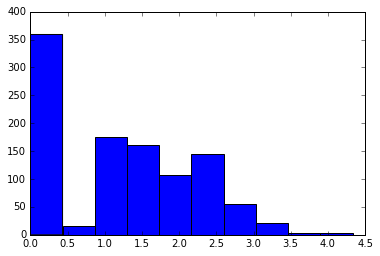

In [332]:
plt.hist(np.log(X["absences"] + 1));

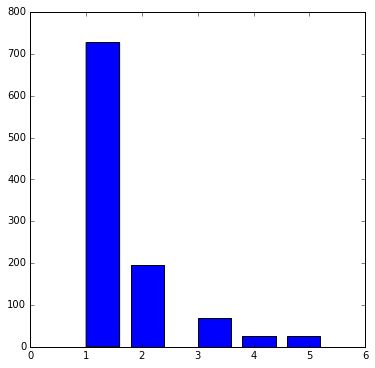

In [346]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.hist(Y.ix[:, 0], width=.6);
ax.set_xlim(0, 6);

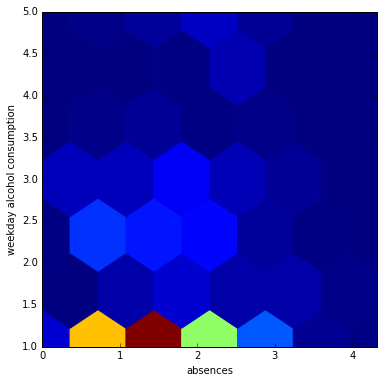

In [328]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.hexbin(np.log(X["absences"]), Y.ix[:, 0], gridsize=6);
ax.set_xlabel("absences");
ax.set_ylabel("weekday alcohol consumption");

Firstly we do see skew to zeros: there are much more people who doesn't drink and attends (almost) all classses. After that we see that those who attend all classes drinks less. Reasonable.
(We use log here because of severe skewness)

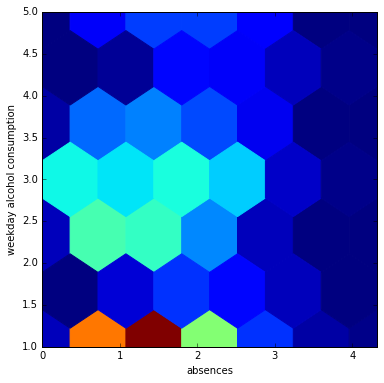

In [327]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.hexbin(np.log(X["absences"]), Y.ix[:, 1], gridsize=6);
ax.set_xlabel("absences");
ax.set_ylabel("weekday alcohol consumption");

We see that alcohol consumption is higher in weekends than that in weekdays (surprise!).

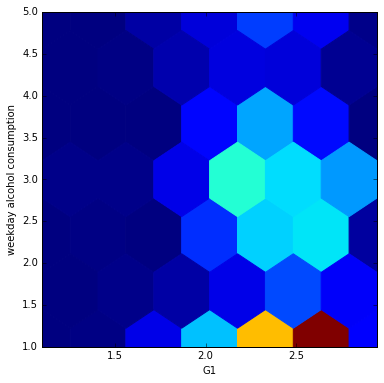

In [329]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.hexbin(np.log(X["G1"]), Y.ix[:, 1], gridsize=6);
ax.set_xlabel("G1");
ax.set_ylabel("weekday alcohol consumption");

Let's retrain our model on the features chosen.

In [428]:
data.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3', 'Course'],
      dtype='object')

In [429]:
data_trim = data[["absences", "G1", "G2", "G3", "romantic", \
            "sex", "activities", "health", "famsup", "freetime"]]

In [430]:
binary_features = ['sex', 'famsup', 'activities', 'romantic']
binary_vectors = pd.get_dummies(data[binary_features], drop_first=True).astype(np.int8)

categorical_features = ['freetime', 'health']
label_vectors = pd.get_dummies(data[categorical_features].astype(object)).astype(np.int8)

numerical_features = ['absences', 'G1', 'G2', 'G3']
numerical_features = data[numerical_features].astype(np.int8)

In [431]:
X_trim = pd.concat([binary_vectors, label_vectors, numerical_features], axis=1)

In [432]:
X_trim.shape

(1044, 18)

Yeah, 18 instead of 10 because of dumminess :)

In [434]:
params = {
    "max_depth": np.arange(8, 12), 
    "n_estimators": np.arange(300, 401, 100)
}

classifier = XGBClassifier()
grid = GridSearchCV(classifier, param_grid=params, n_jobs=4, cv=5, verbose=10)
grid.fit(X_trim, Y.ix[:, 0])

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] n_estimators=300, max_depth=8 ...................................
[CV] n_estimators=300, max_depth=8 ...................................
[CV] n_estimators=300, max_depth=8 ...................................
[CV] n_estimators=300, max_depth=8 ...................................
[CV] .......... n_estimators=300, max_depth=8, score=0.653846 -   2.4s
[CV] n_estimators=300, max_depth=8 ...................................
[CV] .......... n_estimators=300, max_depth=8, score=0.663462 -   2.5s
[CV] .......... n_estimators=300, max_depth=8, score=0.665072 -   2.6s
[CV] n_estimators=400, max_depth=8 ...................................
[CV] n_estimators=400, max_depth=8 ...................................
[CV] .......... n_estimators=300, max_depth=8, score=0.636792 -   2.6s
[CV] n_estimators=400, max_depth=8 ...................................
[CV] .......... n_estimators=300, max_depth=8, score=0.657005 -   2.9s
[CV] n_estimators

[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    5.4s


[CV] .......... n_estimators=400, max_depth=8, score=0.641509 -   3.5s
[CV] n_estimators=400, max_depth=8 ...................................
[CV] .......... n_estimators=400, max_depth=8, score=0.653846 -   3.5s
[CV] n_estimators=300, max_depth=9 ...................................
[CV] .......... n_estimators=400, max_depth=8, score=0.669856 -   3.7s
[CV] n_estimators=300, max_depth=9 ...................................
[CV] .......... n_estimators=400, max_depth=8, score=0.663462 -   3.2s
[CV] n_estimators=300, max_depth=9 ...................................
[CV] .......... n_estimators=300, max_depth=9, score=0.655660 -   2.6s
[CV] n_estimators=300, max_depth=9 ...................................
[CV] .......... n_estimators=300, max_depth=9, score=0.645933 -   2.6s
[CV] n_estimators=300, max_depth=9 ...................................


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    8.9s


[CV] .......... n_estimators=400, max_depth=8, score=0.652174 -   3.3s
[CV] n_estimators=400, max_depth=9 ...................................
[CV] .......... n_estimators=300, max_depth=9, score=0.663462 -   2.6s
[CV] n_estimators=400, max_depth=9 ...................................
[CV] .......... n_estimators=300, max_depth=9, score=0.668269 -   2.6s
[CV] n_estimators=400, max_depth=9 ...................................
[CV] .......... n_estimators=300, max_depth=9, score=0.666667 -   2.7s
[CV] n_estimators=400, max_depth=9 ...................................
[CV] .......... n_estimators=400, max_depth=9, score=0.646226 -   3.3s
[CV] n_estimators=400, max_depth=9 ...................................
[CV] .......... n_estimators=400, max_depth=9, score=0.641148 -   3.3s
[CV] n_estimators=300, max_depth=10 ..................................
[CV] .......... n_estimators=400, max_depth=9, score=0.668269 -   3.4s


[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   14.7s


[CV] n_estimators=300, max_depth=10 ..................................
[CV] .......... n_estimators=400, max_depth=9, score=0.658654 -   3.3s
[CV] n_estimators=300, max_depth=10 ..................................
[CV] .......... n_estimators=400, max_depth=9, score=0.661836 -   3.4s
[CV] n_estimators=300, max_depth=10 ..................................
[CV] ......... n_estimators=300, max_depth=10, score=0.650943 -   2.8s
[CV] n_estimators=300, max_depth=10 ..................................
[CV] ......... n_estimators=300, max_depth=10, score=0.650718 -   2.8s
[CV] n_estimators=400, max_depth=10 ..................................
[CV] ......... n_estimators=300, max_depth=10, score=0.653846 -   2.8s
[CV] n_estimators=400, max_depth=10 ..................................
[CV] ......... n_estimators=300, max_depth=10, score=0.673077 -   2.8s
[CV] n_estimators=400, max_depth=10 ..................................


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   18.9s


[CV] ......... n_estimators=300, max_depth=10, score=0.652174 -   2.7s
[CV] n_estimators=400, max_depth=10 ..................................
[CV] ......... n_estimators=400, max_depth=10, score=0.650943 -   3.5s
[CV] n_estimators=400, max_depth=10 ..................................
[CV] ......... n_estimators=400, max_depth=10, score=0.645933 -   3.5s
[CV] n_estimators=300, max_depth=11 ..................................
[CV] ......... n_estimators=400, max_depth=10, score=0.653846 -   3.5s
[CV] n_estimators=300, max_depth=11 ..................................
[CV] ......... n_estimators=400, max_depth=10, score=0.653846 -   3.4s
[CV] n_estimators=300, max_depth=11 ..................................
[CV] ......... n_estimators=300, max_depth=11, score=0.641509 -   2.8s
[CV] n_estimators=300, max_depth=11 ..................................
[CV] ......... n_estimators=400, max_depth=10, score=0.637681 -   3.5s
[CV] n_estimators=300, max_depth=11 ..................................
[CV] .

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   26.6s


[CV] ......... n_estimators=300, max_depth=11, score=0.658654 -   2.8s
[CV] n_estimators=400, max_depth=11 ..................................
[CV] ......... n_estimators=300, max_depth=11, score=0.666667 -   2.9s
[CV] n_estimators=400, max_depth=11 ..................................
[CV] ......... n_estimators=400, max_depth=11, score=0.650943 -   3.7s
[CV] n_estimators=400, max_depth=11 ..................................
[CV] ......... n_estimators=400, max_depth=11, score=0.631579 -   3.7s
[CV] ......... n_estimators=400, max_depth=11, score=0.653846 -   3.6s
[CV] ......... n_estimators=400, max_depth=11, score=0.644231 -   3.3s
[CV] ......... n_estimators=400, max_depth=11, score=0.657005 -   2.9s


[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:   32.0s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'n_estimators': array([300, 400]), 'max_depth': array([ 8,  9, 10, 11])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=10)

In [436]:
print(grid.best_score_)
print(grid.best_params_)

0.659961685824
{'n_estimators': 300, 'max_depth': 9}


In [447]:
params = {
    "max_depth": np.arange(8, 12), 
    "n_estimators": np.arange(300, 401, 100)
}

classifier = XGBClassifier()
grid = GridSearchCV(classifier, param_grid=params, n_jobs=4, cv=5, verbose=10)
grid.fit(X_trim, Y.ix[:, 1])

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] n_estimators=300, max_depth=8 ...................................
[CV] n_estimators=300, max_depth=8 ...................................
[CV] n_estimators=300, max_depth=8 ...................................
[CV] n_estimators=300, max_depth=8 ...................................
[CV] .......... n_estimators=300, max_depth=8, score=0.457143 -   2.9s
[CV] n_estimators=300, max_depth=8 ...................................
[CV] .......... n_estimators=300, max_depth=8, score=0.410628 -   2.9s
[CV] n_estimators=400, max_depth=8 ...................................
[CV] .......... n_estimators=300, max_depth=8, score=0.347619 -   2.9s
[CV] .......... n_estimators=300, max_depth=8, score=0.438095 -   3.0s
[CV] n_estimators=400, max_depth=8 ...................................
[CV] n_estimators=400, max_depth=8 ...................................
[CV] .......... n_estimators=300, max_depth=8, score=0.376812 -   3.0s
[CV] n_estimators

[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    6.0s


[CV] .......... n_estimators=400, max_depth=8, score=0.452381 -   3.9s
[CV] n_estimators=400, max_depth=8 ...................................
[CV] .......... n_estimators=400, max_depth=8, score=0.433333 -   4.0s
[CV] n_estimators=300, max_depth=9 ...................................
[CV] .......... n_estimators=400, max_depth=8, score=0.347619 -   4.1s
[CV] n_estimators=300, max_depth=9 ...................................
[CV] .......... n_estimators=400, max_depth=8, score=0.396135 -   4.0s
[CV] n_estimators=300, max_depth=9 ...................................
[CV] .......... n_estimators=300, max_depth=9, score=0.433333 -   3.3s
[CV] n_estimators=300, max_depth=9 ...................................
[CV] .......... n_estimators=300, max_depth=9, score=0.480952 -   3.3s
[CV] n_estimators=300, max_depth=9 ...................................


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   10.3s


[CV] .......... n_estimators=400, max_depth=8, score=0.367150 -   3.9s
[CV] n_estimators=400, max_depth=9 ...................................
[CV] .......... n_estimators=300, max_depth=9, score=0.361905 -   3.4s
[CV] n_estimators=400, max_depth=9 ...................................
[CV] .......... n_estimators=300, max_depth=9, score=0.420290 -   3.5s
[CV] n_estimators=400, max_depth=9 ...................................
[CV] .......... n_estimators=300, max_depth=9, score=0.391304 -   3.6s
[CV] n_estimators=400, max_depth=9 ...................................
[CV] .......... n_estimators=400, max_depth=9, score=0.442857 -   4.8s
[CV] n_estimators=400, max_depth=9 ...................................
[CV] .......... n_estimators=400, max_depth=9, score=0.471429 -   4.5s
[CV] n_estimators=300, max_depth=10 ..................................


[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   18.0s


[CV] .......... n_estimators=400, max_depth=9, score=0.361905 -   4.6s
[CV] n_estimators=300, max_depth=10 ..................................
[CV] .......... n_estimators=400, max_depth=9, score=0.415459 -   4.4s
[CV] n_estimators=300, max_depth=10 ..................................
[CV] .......... n_estimators=400, max_depth=9, score=0.376812 -   4.1s
[CV] n_estimators=300, max_depth=10 ..................................
[CV] ......... n_estimators=300, max_depth=10, score=0.442857 -   3.5s
[CV] n_estimators=300, max_depth=10 ..................................
[CV] ......... n_estimators=300, max_depth=10, score=0.447619 -   3.4s
[CV] n_estimators=400, max_depth=10 ..................................
[CV] ......... n_estimators=300, max_depth=10, score=0.380952 -   3.5s
[CV] n_estimators=400, max_depth=10 ..................................
[CV] ......... n_estimators=300, max_depth=10, score=0.391304 -   3.4s
[CV] n_estimators=400, max_depth=10 ..................................


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   23.3s


[CV] ......... n_estimators=300, max_depth=10, score=0.376812 -   3.4s
[CV] n_estimators=400, max_depth=10 ..................................
[CV] ......... n_estimators=400, max_depth=10, score=0.442857 -   4.4s
[CV] n_estimators=400, max_depth=10 ..................................
[CV] ......... n_estimators=400, max_depth=10, score=0.438095 -   4.6s
[CV] n_estimators=300, max_depth=11 ..................................
[CV] ......... n_estimators=400, max_depth=10, score=0.376190 -   4.7s
[CV] n_estimators=300, max_depth=11 ..................................
[CV] ......... n_estimators=400, max_depth=10, score=0.386473 -   5.0s
[CV] n_estimators=300, max_depth=11 ..................................
[CV] ......... n_estimators=300, max_depth=11, score=0.419048 -   4.3s
[CV] n_estimators=300, max_depth=11 ..................................
[CV] ......... n_estimators=400, max_depth=10, score=0.357488 -   5.2s
[CV] n_estimators=300, max_depth=11 ..................................
[CV] .

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   34.3s


[CV] ......... n_estimators=300, max_depth=11, score=0.396135 -   4.7s
[CV] n_estimators=400, max_depth=11 ..................................
[CV] ......... n_estimators=300, max_depth=11, score=0.362319 -   4.4s
[CV] n_estimators=400, max_depth=11 ..................................
[CV] ......... n_estimators=400, max_depth=11, score=0.428571 -   5.4s
[CV] n_estimators=400, max_depth=11 ..................................
[CV] ......... n_estimators=400, max_depth=11, score=0.447619 -   4.9s
[CV] ......... n_estimators=400, max_depth=11, score=0.352381 -   4.4s
[CV] ......... n_estimators=400, max_depth=11, score=0.396135 -   4.3s
[CV] ......... n_estimators=400, max_depth=11, score=0.362319 -   3.5s


[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:   41.2s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'n_estimators': array([300, 400]), 'max_depth': array([ 8,  9, 10, 11])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=10)

In [448]:
print(grid.best_score_)
print(grid.best_params_)

0.417624521073
{'n_estimators': 300, 'max_depth': 9}


So, here are results. They are a bit modest. There are several ways for subsequent improvement:  
 * train linear models (one-vs-one or one-vs-rest LinearSVC)
 * train knn, however a sophisticated metric is needed
 * apply stacking over these three models